As the data was originally stored in an RData file, we will need to read and make some preprocessing before passing it on to Julia. To do this we will use the RCall.jl package. Note that using it requires that R is installed in the users computer. In particular, we will use the new\_168\_2024\_HORARIOS\_pm2\_n\_R.RData file which can be converted into an $M \times 173$, $M = 761$ being the total numer of curves, with the following columns: 
1. Station (String), corresponds to the station of a curve (row). 
2. unit\_n, this value equals the week number of a curve minus one. i.e. week number of a particular row = unit\_n + 1. 
3. date
4. date\_lower
5. date\_upper
6. Hourt, $t \in \{1,2,...,168\}$. 

In [51]:
using RCall, LinearAlgebra


R""" 
#We will load the dplyr package for easier data management in R. 
#Note that, most likely, this will print a warning fromo RCall.jl. This is normal. 
library(dplyr) #Loads the dplyr package into R. 

 data <- load("new_168_2024_HORARIOS_pm2_n_R.RData") #Loads the desired file into R's workspace.
 data <- r_data #Obtains the data frame with the desired data. 
 head(data) #Prints the top rows of data. 

 #For confort, we will now convert unit_n to be the actuall week number of the curves.

 data <- data%>%mutate(unit_n = unit_n + 1) #Sets unit_n = unit_n + 1. 
 Y_obs <- as.matrix(data[, 6:173])# Gets an M x T, T = 168, matrix with the functional observations. 
                                  #Note that these are already ordered by Station (i.e. by their alphabetical order), 
                                  #and unit_n in an increasing fashion. 
 head(Y_obs) #Prints the top rows of the curves. 

 #We may observe that we already have one of the inputs for flfosr, we are only missing a design matrix and an M_rep vector. 
 #Before obtaning this components, we will give some explanation of what we are going to do. 
 """

RObject{RealSxp}
  Hour1 Hour2 Hour3 Hour4 Hour5 Hour6 Hour7 Hour8 Hour9 Hour10 Hour11 Hour12
0    10     6     3     4     4    14     5     2     4      6     15     17
1    10   NaN    13   NaN    13   NaN     8   NaN     5    NaN      3    NaN
2     8    16    17    16    21    19    16    12     8     10     15     22
3    22    22    18    19    20    22    24    27    38     43     45     43
4     6   NaN     6   NaN     3   NaN     8   NaN     4    NaN    NaN    NaN
5     3     3     2     6     2     1   NaN     0     1      4      5      3
  Hour13 Hour14 Hour15 Hour16 Hour17 Hour18 Hour19 Hour20 Hour21 Hour22 Hour23
0     12     20     22     26     27      6    NaN      3      4      9     11
1      2    NaN      1    NaN      3    NaN      2    NaN      3    NaN     12
2     18     20     12     17     22     28     18     19      7      5      3
3     44     55     41     32     21     25     32     33     24     24     16
4      1    NaN    NaN    NaN      3    NaN      

Let us recall that the FMM presented in Johansson L.(2025), with a mix of our and its notation, is of the form 

$$Y_{ij}(\tau) = \mu(\tau) + \eta_j(\tau) +  \gamma_i(\tau) + \omega_{ij}(\tau) + \varepsilon_{ij}(\tau)$$

where $\mu(\tau)$ represents a global mean, $\eta_j(\tau)$ corresponds to a global week level fixed effect, $\gamma_i(\tau)$ is a subject specific random effect that in the abscence of $\eta_j(\tau)$ determines between subject variation, and $\omega_{ij}(\tau)$ as a subject-visit specific efect which deteremines within subject variation. 

How should this translate into our model and our design matrix. For starters, for identifiability,  so our design matrix should include a column with all ones. i.e. the first one. 


To make this 

In [ ]:


R""" 
library(pracma) #Loads the pracma package, this contains the function ones which will be used 
                #later. 

 M <- dim(Y_obs)[1] #Gets the total number of curves M = M1+M2+...+MN
 T <- dim(Y_obs)[2] #Gets the total number of hour recordings. 

 unique_unit_n <- sort(unique(data$unit_n)) #Gets the unique recorded weeks. 
 L <- length(unique_unit_n) #Gets L, in this case the total number of unique weeks. 


 X <- ones(M, L+1) #Creates an M x L +1 matrix filled with ones. 
                   #X will be modified to obtain our final design matrix. 

unit_n <- data$unit_n #Gets the column with the week number. 

#The following for modifies the columns of X (except for the first one)
#and sets it to a column of zeros and ones where a curve has a one entry if
#it was observed on the week unique_unit_n[l-1]. 

#The previous is accomplished by taking unit_n, and comparing it entry by entry to 
#to a vector filled with the value unique_unit_m[l-1]. i.e. unit_n == rep(unique_unit_n[l-1], M)
#produces an M-dimensional vector filled with TRUE and FALSE values and
#, when implementing as.numeric, it becomes a vector of 0's and 1's. 

for (l in 2:(L+1))
    X[, l] <- as.numeric(unit_n == rep(unique_unit_n[l-1], M) )

# head(X) #Prints the top rows of the design matrix X. 
Station <- as.numeric(table(data$Station)) #This counts the number of appearences of each station. i.e. this will become our
                                           #M_rep. 

 """

RObject{RealSxp}
 [1] 48 40 43 47 41 46 35 30 37 48 27 40 37 49 46 43 36 32 36


Given this, we now have all of the ingredients to run FastBayesFMMs! We only need to pass everything to Julia. Fortunately, as Station, Y\_obs, and X are vector and matrices respectively. Thus, we only need to pass them to Julia. 

In [53]:
M_rep = rcopy(Vector{Int64}, R"as.vector(Station)") #Copies Station and defines it as M_rep
Y = rcopy(Matrix{Float64}, R"t(Y_obs)") #Copies Y_obs as a Matrix{Float64} object.
X = rcopy(Matrix{Float64}, R"X") #Copies X as a Matrix{Float64} object. 

#display(M_rep) #As a sanity check, sees that the entries of M_rep and Station coincide. 
#display(X) #As a sanity check, looks at X. 


761×52 Matrix{Float64}:
 1.0  1.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  1.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  1.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  1.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  1.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  1.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  1.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0  …  0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0     0.0  0.0  0.0  0.0  0.0  0.0  0.0
 1.0  0.0  0.0  0.0  0.0  0.0  0.0  0.0 

Now, for what we've waited for, we can implement flfosr. This is the main method in the FastBayesFMMs package. This method takes the following essential inputs: 

1. Y: Matrix{Float64} of observations  of dimension T x M with M = M1 + M2 + ... + MN
2. X: Matrix{Float64} design matrix of dimension M x L+1 with M = M1 + M2 + ... + MN
3. M_rep: Vector{Int64} of size N whose ith entry corresponds to Mi, e.g. M_rep[i] = Mi
4. K: Int64, number of basis functions. 
5. S: Int64, number of MCMC iterations. 


The following assumptions are made with respect to the inputs: 

1. It is assumed that the order in Y's columns goes in accordance to the entries in M_rep. This in the sense that, knowing that M_rep[1] = M1, then Y[:, 1:M1] are the observations of the 1st subject, Y[:, M1+1: M1+M2] correspond to the obsevations of subject 2, etc. 

2. It is assumed that X's rows are ordered in accordance to the columns of Y. That is, if Y[:,l] corresponds to the j-th visit of the i-th subject, then X[l,:] has its corresponding covariates.

In addition, flfosr accepts the following additional inputs:

1. K: Int64, corresponds to the total number of basis functions to use. Defaults to 10. 
2. S\_burn: Int64, tells flfosr how many iterations will be dedicated to the burn in period of the MCMC. 
3. a\_alph, b\_alph: Float64, tells the prior hyperparameters for the fixed effect variances. i.e. the $\sigma_{\alpha_\ell}^2$'s. They are both set to 0.1 by default. 
4. a\_gamm, b\_gamm: Float64, tells the prior hyperparameters for the subject effect variances $\sigma_\gamma^2$. Both are set to 0.1 by default. 
5. a\_omeg, b\_omeg: Float64, tells the prior hyperparameters for the visit specific efect variances, i.e. $\sigma_{\omega_i}^2$'s. Both are set to 0.1 by default. 


With the previous in mind, we will only provide the necessary inputs and change the number of basis functions to $K  = 30$. In addition, we will store our results in a variable called results_flfosr. 

In [54]:
#using FastBayesFMMs #Includes the FastBayesFMMs package. 
include("src\\FastBayesFMMs.jl")
include("src\\MCMC.jl")

results_flfosr = flfosr(Y = Y, X = X, M_rep = M_rep, K = 30)

A total of 17526 missing values found!!
FLFOSR will procede with intermediate imputations.
Be aware that this increases computational cost and confidence bands!
Might be worth to explore missingness


On iteration 200 from 2000
On iteration 400 from 2000
On iteration 600 from 2000
On iteration 800 from 2000
On iteration 1000 from 2000
On iteration 1200 from 2000
On iteration 1400 from 2000
On iteration 1600 from 2000
On iteration 1800 from 2000
On iteration 2000 from 2000


Dict{String, Array{Float64}} with 10 entries:
  "B"              => [0.0771517 -0.132838 … -0.361143 -0.430376; 0.0771517 -0.…
  "alpha_post"     => [232.25 -69.8752 … -17.2012 57.5847; 8.7665 16.0934 … -14…
  "X"              => [1.0 1.0 … 0.0 0.0; 1.0 0.0 … 0.0 0.0; … ; 1.0 0.0 … 1.0 …
  "ga_post"        => [-40.0983 -49.1759 … 16.7637 19.6333; -7.27215 -6.68092 ……
  "w_post"         => [-17.8046 -36.4442 … -27.3188 4.92848; -5.00397 0.0156075…
  "sig_gamma_post" => [86.8883, 85.5711, 85.428, 77.3795, 81.2621, 81.4001, 81.…
  "sig_omega_post" => [104.046 103.687 … 116.112 115.079; 102.158 94.4457 … 104…
  "sig_eps_post"   => [40.4419, 40.4619, 40.3239, 40.5126, 40.317, 40.1261, 40.…
  "alpha_postf"    => [14.9672 -0.0447787 … -5.33437 -4.93349; 16.7706 -1.42311…
  "sig_alpha_post" => [2471.06 1459.71 … 1135.9 2095.5; 454.344 328.785 … 407.5…

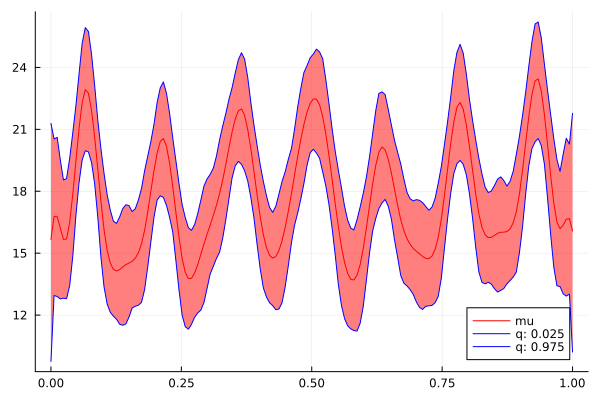

In [55]:
include("src\\VizUtils.jl")
alpha_postf = results_flfosr["alpha_postf"]
plotf_mean_q(alpha_postf[:,1 , :]    )